In [72]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import dask.dataframe as dd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_curve, roc_curve, auc, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 1. Baseline

In [2]:
def train_test_prep(df, train=True):
    """
    Train and test sets preparation function:
        - types convertion to save memory
        - drop unnecessary column
        - date format
    """
    
    df = df.copy()
    df = df.astype({
        'id': 'uint32',
        'vas_id': 'uint8'
    })
    
    if train:
        df = df.astype({'target': 'uint8'})
        
    df = df.drop(columns=['Unnamed: 0'])
#     df = format_date(df, 'buy_time')
    
    return df

In [3]:
def features_prep(features_dask_df, ids_train_list, ids_test_list):
    """
    Features dataset cut function:
        - leave only actual ids which are contained in train and test datasets
        - drop Unnamed column
        - drop constant columns
        - convert types
        - date format
        - reset index
        - return pandas df instead of dask df
    """
    
    ids_list = np.unique(np.append(ids_train_list, ids_test_list))
    features_pd_df = features_dask_df.loc[features_dask_df['id'].isin(ids_list)].compute()
    features_pd_df = features_pd_df.drop(columns=['Unnamed: 0'], axis=1)
#     features_pd_df = features_pd_df[[col for col 
#                                      in list(features_pd_df) 
#                                      if len(features_pd_df[col].unique()) > 1]]
    
    features_pd_df = features_pd_df.astype({'id': 'uint32'})
#     col_should_be_int = features_pd_df.select_dtypes(include=['float']).applymap(float.is_integer).all()
#     float_to_int_cols = col_should_be_int[col_should_be_int].index
#     features_pd_df.loc[:, float_to_int_cols] = features_pd_df.loc[:, float_to_int_cols].astype('int32')
    
#     constant_cols = find_not_representative_cols(features_pd_df, 0.999)
#     features_pd_df.drop(columns=constant_cols, inplace=True)
    
#     features_pd_df = format_date(features_pd_df, 'buy_time')
#     bin_feat = find_categorical_features(features_pd_df, 3)
#     cat_feat = find_categorical_features(features_pd_df, 30, remove_bin_features=True)
#     features_pd_df = cat_feat_label_encode(features_pd_df, list(bin_feat.keys()))
#     features_pd_df = pd.get_dummies(features_pd_df, columns=list(cat_feat.keys()), prefix=list(cat_feat.keys()))
    
    features_pd_df.reset_index(drop=True, inplace=True)
    
    return features_pd_df

In [4]:
def prepare_df_with_features(df, features, train=True):
    """
    function to combine train/test datasets with features
    working with following algorithm:
    - create an empty "ready_features" list which will be filled with values from features df
    according to user id and closest profile in time (indexes are the same like in "data" df)
    - convert "ready_features" list into dataframe
    - merge 2 dataframes by index
    - if train parameter is true move 'target' column to the end
    """
    ready_features = []
    
    for idx in df.index:
        processing_series = features.loc[(features['id'] == df.at[idx, 'id'])]
        if processing_series.shape[0] == 1:
            ready_features.append(processing_series.values[0])
        else:
            check_diff = np.abs(
                processing_series['buy_time'] - df.at[idx, 'buy_time'])
            nearest_series_id = check_diff[check_diff == np.min(check_diff)].index[0]
            ready_features.append(processing_series.loc[nearest_series_id].values)
                
    
    ready_features_df = pd.DataFrame(ready_features, columns=features.columns)
    merged_df = pd.merge(df, ready_features_df.iloc[:, 3:], left_index=True, right_index=True)
     
    if train:
        merged_df = merged_df[[col for col in merged_df.columns if col != 'target'] + ['target']]
        
    return merged_df

### 1.1 Чтение и слияние датасетов

In [5]:
# input
TRAINSET_PATH = 'data_train.csv'
TESTSET_PATH = 'data_test.csv'
FEATURES_PATH = 'features-1.csv'

# output
TRAIN_DF_PREP_PATH = 'df_train_prep.csv'
TEST_DF_PREP_PATH = 'df_test_prep.csv'
FEATURES_DF_PREP_PATH = 'features_df_prep.csv'
TRAIN_WITH_FEATURES_PATH = 'df_train_with_feat.csv'
TEST_WITH_FEATURES_PATH = 'df_test_with_feat.csv'

In [6]:
# df_train = pd.read_csv(TRAINSET_PATH)
# df_test = pd.read_csv(TESTSET_PATH)
# features_df = dd.read_csv(FEATURES_PATH, sep="\t")

In [7]:
# df_train = train_test_prep(df_train)
# df_test = train_test_prep(df_test, train=False)
# df_features = features_prep(features_df, df_train['id'].values, df_test['id'].values)

In [8]:
# df_train_feat = prepare_df_with_features(df_train, df_features, train=True)
# df_test_feat = prepare_df_with_features(df_test, df_features, train=False)

In [9]:
# df_train_feat.to_csv(TRAIN_WITH_FEATURES_PATH, index=False, encoding='utf-8')

In [10]:
df_train_feat = pd.read_csv(TRAIN_WITH_FEATURES_PATH)

In [11]:
# Разделим признаки и целевую переменную
df_copy = df_train_feat.copy()

X = df_copy.drop('target', axis=1)
y = df_copy['target']

In [12]:
print("ID уникален? ", X.index.is_unique)
print("Есть ли дубли в строках?", X.duplicated().sum())
print("Сколько процентов признаков могут принимать null-значениями? %d%%" % float((X.isnull().sum() > 0).sum()/X.shape[1]*100))

ID уникален?  True
Есть ли дубли в строках? 0
Сколько процентов признаков могут принимать null-значениями? 0%


In [13]:
# print(f'Размер тренировочного сета: {df_train.shape}')
# print(f'Размер тестового сета: {df_test.shape}')

In [14]:
# unique_ids_train = len(df_train['id'].unique())
# unique_ids_test = len(df_test['id'].unique())

# print(f'Уникальных абонентов в тренировочном сете: {unique_ids_train}')
# print(f'Уникальных абонентов в тестовом сете: {unique_ids_test}')

In [15]:
df_train_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Columns: 256 entries, id to target
dtypes: float64(252), int64(4)
memory usage: 1.6 GB


In [93]:
df_train_feat.head()

,id,vas_id,buy_time,1,2,3,4,5,6,7,...,244,245,246,247,248,249,250,251,252,target
0,540968,8,1537131600,327.360888,-45.500786,274.753202,-50.918246,253.64821,49.15382,195.883903,...,-613.770792,-20.996269,-37.630448,-28.747724,4.167111,7.305572,-12.175933,21.54386,0.0,0
1,1454121,4,1531688400,238.430888,533.329214,274.803202,527.911754,253.69821,-16.08618,-65.076097,...,-613.770792,-25.996269,-19.630448,-278.747724,-24.832889,-0.694428,-11.175933,-0.45614,0.0,0
2,2458816,1,1534107600,-95.469112,-106.080786,-139.596798,-111.498246,-142.90179,-16.08618,-65.076097,...,-613.770792,-25.996269,-37.630448,-304.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0,0
3,3535012,5,1535922000,12.970888,54.079214,-9.116798,48.661754,-30.22179,60.17382,87.453903,...,-613.770792,-25.996269,-18.630448,-133.747724,-14.832889,-0.694428,-1.175933,-0.45614,0.0,0
4,1693214,1,1535922000,295.240888,64.679214,344.283202,59.261754,323.17821,-16.08618,-65.076097,...,-612.770792,-22.996269,-32.630448,-127.747724,-4.832889,-0.694428,-12.175933,-0.45614,0.0,0


### 1.2 Разделение на train/test

0    0.927631
1    0.072369
Name: target, dtype: float64
0    771467
1     60186
Name: target, dtype: int64


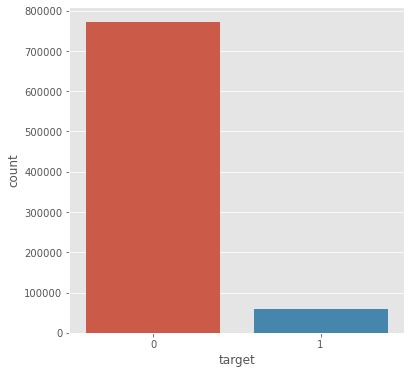

In [16]:
plt.rcParams['figure.figsize'] = (6, 6)
sns.countplot(x='target', data=df_train_feat)
print(y.value_counts()/y.shape)
print(y.value_counts())

Датасет сильно разбалансирован, однако для baseline модели не будем вносить никакие изменения

In [12]:
# Зафиксируем значение random_state для воспроизводимости результатов.
RANDOM_STATE = 888

train_idx, test_idx = train_test_split(X.index, test_size=0.25, random_state=RANDOM_STATE)

y_train, y_test = y.loc[train_idx], y.loc[test_idx]
X_train, X_test = X.loc[train_idx], X.loc[test_idx]

print("Train")
print(y.loc[train_idx].value_counts()/train_idx.shape[0])
print()
print("Test")
print(y.loc[test_idx].value_counts()/test_idx.shape[0])

Train
0    0.927521
1    0.072479
Name: target, dtype: float64

Test
0    0.927961
1    0.072039
Name: target, dtype: float64


### 1.3  Baseline модели и кроссвалидация

In [109]:
y_0 = np.zeros(len(y))
print(classification_report(y, y_0))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96    771467
           1       0.00      0.00      0.00     60186

    accuracy                           0.93    831653
   macro avg       0.46      0.50      0.48    831653
weighted avg       0.86      0.93      0.89    831653



Из графиков и отчета выше видно, что датасет сильно разбалансирован, а наивный классификатор, предсказывающий все время значение 0, будет иметь f1 macro score 48%! Думаю, это величина отлично подойдет в качестве отправной точки.
Далее будем двигаться по следующему плану: 
* отсортируем и предобработаем признаки простейшим образом
* проведем балансировку тренировочного датасета
* реализуем функцию кросс-валидации с использованием балансировки
* оценим качество нескольких простейших моделей и выберем из них одну
* попробуем уменьшить размерность датасета по методу главных компонент
* проведем отбор признаков
* настроим гиперпараметры модели
* создадим финальную модель, построим предсказания и сохраним ее

**Roc и PR кривые**

In [13]:
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")

In [64]:
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

In [68]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

**Матрица смежности**

In [14]:
def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# TN                FP(Type II error)
# 
# FN(Type I error)  TP

In [15]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

## 2. Модификация датасета

### 2.1 Определение типа признаков

In [16]:
def find_not_representative_cols(df, thresh):
    """
    Function that finds columns with one dominant value and small variaty
    :param df: - Dataframe object
    :param thresh: - Threshold of values variaty from 0 to 1
    :param drop: - Set this parameter as True if you want to return modified df without found columns 
    :return: - List of columns whos have values variaty is less than threshold
    """
    not_representative_columns = set()
    for col in df.columns.values:
        total_rows = df.shape[0]
        largest_value = df[col].value_counts().values[0]
        check_div = largest_value / total_rows

        if check_div > thresh:
            not_representative_columns.add(col)
            
    return not_representative_columns

In [17]:
def find_categorical_features(df, thresh, remove_bin_features=False):
    """
    Find features that probably can be categorical
    :param df: - Dataframe object
    :param thresh: - The number of values less than which the feature will be considered categorical 
                    (any positive number)
    :param remove_bin_features: - Boolean parameter. If True features with only 2 unique values will not be add 
                                  to the list
    :return: - Dictionary with names of features that can be categorical as keys and their numbers of different values
    """
    cols_not_to_add_to_dict = ['buy_time', 'target']
    
    if remove_bin_features:
        could_be_cat = {colname
                        for colname in df.columns 
                        if (df[colname].unique().shape[0] < thresh) &
                        (df[colname].unique().shape[0] > 2) &
                        (colname not in cols_not_to_add_to_dict)}
    
    else:
        could_be_cat = {colname 
                        for colname in df.columns 
                        if (df[colname].unique().shape[0] < thresh) &
                        (colname not in cols_not_to_add_to_dict)}
    return could_be_cat

In [18]:
X_nunique = X.nunique()

In [19]:
f_all = set(X_nunique.index.tolist())
len(f_all)

255

**Нерепрезентативные признаки (константные + с одним доминирующем значением (99.9%) + не несущие полезной информации)**

In [20]:
f_notrepr = find_not_representative_cols(X, 0.999)
f_notrepr.add('buy_time')
f_notrepr.add('id')
len(f_notrepr)

35

**buy_time** отмечен как нерепрезентативный, так как представленный период не позволяет определить какую-либо зависимость принятия или отклонения предложения от времени (сезонность), а в тесте будет представлен совершенно новый период для модели.<br>
Поясню, что предоставленные периоды имеют недельный интервал, данных за аналогичный период из тестового датасета нет, а разбиение по неделям не позволяет определить какую-либо сезонность внутри месяца

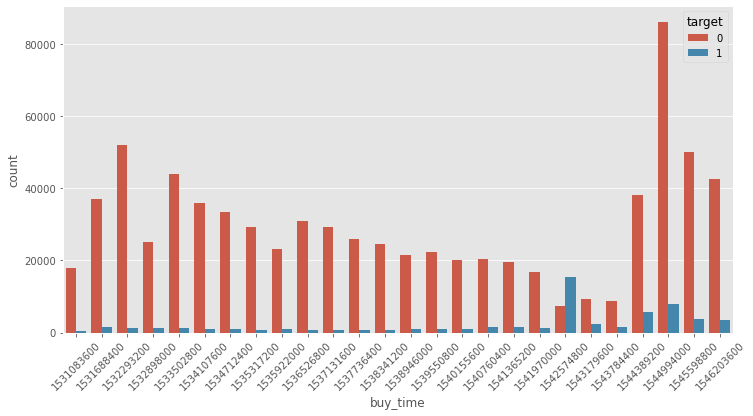

In [21]:
plt.rcParams['figure.figsize'] = (12, 6)
result = X.groupby(["buy_time"]).agg({'id' :'count'}).reset_index().sort_values('buy_time')
chart = sns.countplot(x='buy_time', hue=y, data=X, order=result['buy_time'])
chart = chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

**Бинарные признаки**

In [22]:
f_bin = find_categorical_features(X, 3)
f_bin = f_bin - f_notrepr
len(f_bin)

16

**Категориальные признаки**

In [23]:
f_categorical = find_categorical_features(X, 16, remove_bin_features=True)
f_categorical = f_categorical - f_notrepr
len(f_categorical)

7

**Числовые признаки**

In [24]:
f_numeric = f_all - (f_notrepr | f_bin | f_categorical)
len(f_numeric)

197

In [25]:
assert(X_nunique.shape[0] == len(f_bin) + len(f_numeric) + len(f_categorical) + len(f_notrepr))

In [26]:
print('f_all:', len(f_all))
print()
print('f_notrepr:', len(f_notrepr))
print('f_bin:', len(f_bin))
print('f_categorical:', len(f_categorical))
print('f_numeric:', len(f_numeric))

f_ok = list(f_bin | f_categorical | f_numeric)
f_bin, f_categorical, f_numeric = list(f_bin), list(f_categorical), list(f_numeric)

f_all: 255

f_notrepr: 35
f_bin: 16
f_categorical: 7
f_numeric: 197


## 3. Pipeline

### 3.1 ColumnSelector

In [27]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

### 3.2 Pipeline обработки признаков

In [102]:
f_prep_pipeline = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_bin),
            OneHotEncoder(handle_unknown='ignore')
        ))
    ])
)

In [103]:
f_prep_pipeline.fit(X_train)

n_features = f_prep_pipeline.transform(X_test).shape[1]
n_features

292

### 3.3 Кросс-валидация для сбалансированного датасета 

При кросс-валидации на сбалансированном датасете возникает проблема, когда на каждом шаге кросс-валидации обучение и валидация модели происходит на сбалансированных данных, что позже сказывается при тестировании модели на реальных (несбалансированных) данных. Таким образом **необходимо применять балансировку на каждом шаге кросс-валидации исключительно к тренировочному набору данных**, не затрагивая валидационный. Это позволит корректнее оценить качество моделей на реальных данных.

In [30]:
def run_balance_and_cv(estimator, sampler, cv, X, y, model_name=""):
    cv = cv
    cross_val_accuracy_list = []
    cross_val_f1_list = []
    cross_val_f1_macro_list = []
    
    for train_index, validation_index in cv.split(X, y):
        train, validation = X.iloc[train_index], X.iloc[validation_index]
        target_train, target_validation = y.iloc[train_index], y.iloc[validation_index]
        sampler = sampler
        train_balanced, target_train_balanced = sampler.fit_resample(train, target_train)
        
        estimator.fit(train_balanced, target_train_balanced)
        
        validation_preds = estimator.predict(validation)
        
        cross_val_accuracy_list.append(accuracy_score(target_validation, validation_preds))
        cross_val_f1_list.append(f1_score(target_validation, validation_preds))
        cross_val_f1_macro_list.append(f1_score(target_validation, validation_preds, average='macro'))
        
    msg = (f'{model_name}\n'
           f'accuracy: {np.mean(cross_val_accuracy_list):.2f}, f1: {np.mean(cross_val_f1_list):.2f}, ' 
           f'f1_macro: {np.mean(cross_val_f1_macro_list):.2f}\n')
    print(msg)

## 4. Выбор модели для дальнейшней настройки

### 4.1 Выбор классификатора

Так как тестовый датасет имеет достаточно большой объем данных можно на начальном этапе воспользоваться балансировкой методами андерсемплинга, то есть выбора наблюдений из доминирующего класса равных по количеству наблюдениям из меньшего класса. Самый простой метод - случайный выбор наблюдений. <br>
После выбора модели попробуем различные более сложные техники балансировки, которые способны поднять точность модели <br>
<br>
(Дополнительно можно было протестировать KNN и метод опорных векторов, но эти методы сильно ресурсозатратные, поэтому не включены в исследование)


In [31]:
strkfold_cv = StratifiedKFold(n_splits=4, random_state=RANDOM_STATE, shuffle=True)
rus = RandomUnderSampler(random_state=RANDOM_STATE)

In [126]:
# prepare models
models = []
models.append(('LR', LogisticRegression(n_jobs=4, random_state=RANDOM_STATE)))
models.append(('CART', DecisionTreeClassifier(random_state=RANDOM_STATE)))
models.append(('RFC', RandomForestClassifier(n_jobs=4, random_state=RANDOM_STATE)))
models.append(('XGB', XGBClassifier(n_jobs=4, random_state=RANDOM_STATE)))
models.append(('LGBM', LGBMClassifier(n_jobs=4, random_state=RANDOM_STATE)))

# evaluate each model in turn
for name, model in models:
    pipeline = make_pipeline(f_prep_pipeline, model)
    run_balance_and_cv(pipeline, rus, strkfold_cv, X_train, y_train, model_name=name)

LR
accuracy: 0.86, f1: 0.45, f1_macro: 0.69

CART
accuracy: 0.70, f1: 0.26, f1_macro: 0.54

RFC
accuracy: 0.86, f1: 0.45, f1_macro: 0.68

XGB
accuracy: 0.86, f1: 0.45, f1_macro: 0.69

LGBM
accuracy: 0.86, f1: 0.45, f1_macro: 0.69



Видно, что линейная регрессия и оба бустинговых алгоритма дают одинаковый результат. В качестве модели для дальнейшего улучшения выберем XGBoost, так как исходя из личных предпочтений и природы исходных данных (смешанные, преимущественно числовые данные размерзности до 10^7), этот алгоритм, на мой взгляд, подходит лучше всего. Не отрицаю, что выбор может быть так же сделан в пользу более скоростного LGBM

### 4.2 Тестирование различных методов балансировки

In [32]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler

In [137]:
list_of_resamplers = []

list_of_resamplers.append(("NM1", NearMiss(version=1, n_jobs=4)))
list_of_resamplers.append(("TL", TomekLinks(n_jobs=4)))
list_of_resamplers.append(("ROS", RandomOverSampler(random_state=RANDOM_STATE)))
list_of_resamplers.append(('SMOTE', SMOTE(n_jobs=4, random_state=RANDOM_STATE)))
list_of_resamplers.append(('SMOTEENN', SMOTEENN(n_jobs=4, random_state=RANDOM_STATE)))
list_of_resamplers.append(('SMOTETomek', SMOTETomek(n_jobs=4, random_state=RANDOM_STATE)))

strkfold_2 = StratifiedKFold(n_splits=2, random_state=RANDOM_STATE, shuffle=True)
pipeline = make_pipeline(f_prep_pipeline, XGBClassifier(n_jobs=4, random_state=RANDOM_STATE))

for name, resampler in list_of_resamplers:    
    run_balance_and_cv(pipeline, resampler, strkfold_2, X_train, y_train, model_name=name)

NM1
accuracy: 0.64, f1: 0.09, f1_macro: 0.40

TL
accuracy: 0.93, f1: 0.01, f1_macro: 0.49

ROS
accuracy: 0.86, f1: 0.45, f1_macro: 0.69

SMOTE
accuracy: 0.83, f1: 0.41, f1_macro: 0.65

SMOTEENN
accuracy: 0.86, f1: 0.39, f1_macro: 0.66

SMOTETomek
accuracy: 0.87, f1: 0.37, f1_macro: 0.65



Рандомные алгоритмы дают больший f1_score и затрачивают меньше времени на реализацию, будем продолжать использовать RandomUnderSampler

### 4.3 Понижение размерности

Перед тем как приступить к отбору признаков попробуем понизить размерность численных признаков, сохранив около 90% дисперсии и протестировать модель на них

In [33]:
from sklearn.decomposition import PCA

In [34]:
# Измененная функция под xgb с дополнительными параметрами
def run_balance_and_cv_xgb(estimator, sampler, cv, X, y, model_name=""):
    cv = cv
    cross_val_accuracy_list = []
    cross_val_f1_list = []
    cross_val_f1_macro_list = []
    
    for train_index, validation_index in cv.split(X, y):
        train, validation = X.iloc[train_index], X.iloc[validation_index]
        target_train, target_validation = y.iloc[train_index], y.iloc[validation_index]
        sampler = sampler
        train_balanced, target_train_balanced = sampler.fit_resample(train, target_train)
        
        estimator.set_params(clf__eval_set=[validation, target_validation], 
                             clf__early_stopping_rounds=10).fit(train_balanced, target_train_balanced)
        
        validation_preds = estimator.predict(validation)
        
        cross_val_accuracy_list.append(accuracy_score(target_validation, validation_preds))
        cross_val_f1_list.append(f1_score(target_validation, validation_preds))
        cross_val_f1_macro_list.append(f1_score(target_validation, validation_preds, average='macro'))
        
    msg = (f'{model_name}\n'
           f'accuracy: {np.mean(cross_val_accuracy_list):.2f}, f1: {np.mean(cross_val_f1_list):.2f}, ' 
           f'f1_macro: {np.mean(cross_val_f1_macro_list):.2f}\n')
    print(msg)

In [35]:
f_prep_pca_pipe = make_pipeline(
    ColumnSelector(columns=f_ok),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(f_numeric),
            StandardScaler(),
            PCA(n_components=100)
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(f_categorical),
            OneHotEncoder(handle_unknown='ignore')
        )),
        ("boolean_features", make_pipeline(
            ColumnSelector(f_bin),
            OneHotEncoder(drop='first', handle_unknown='error')
        ))
    ])
)

In [36]:
xgb_pca_pipeline = Pipeline([
    ('prep', f_prep_pca_pipe),
    ('clf', XGBClassifier(n_jobs=4, random_state=RANDOM_STATE))
])

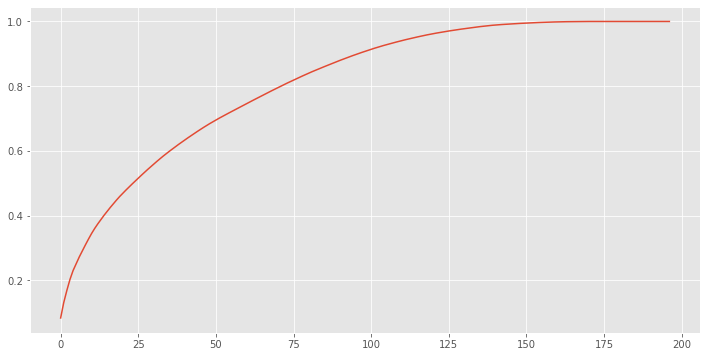

In [35]:
X_for_pca = X_train[f_numeric]
scaler = StandardScaler()
X_for_pca = scaler.fit_transform(X_for_pca)
pca = PCA(n_components=X_for_pca.shape[1])
pca.fit(X_for_pca)
plt.plot(np.cumsum((pca.explained_variance_ratio_)))

In [36]:
np.cumsum((pca.explained_variance_ratio_))[100]

0.914042316031274

In [40]:
run_balance_and_cv_xgb(xgb_pca_pipeline, rus, strkfold_cv, X_train, y_train, model_name='xgb_pca')

xgb_pca
accuracy: 0.86, f1: 0.45, f1_macro: 0.69



Видно, что PCA не дал результатов 

## 5. Настройка гиперпараметров

Для настройки гиперпараметров воспользуемся библиотекой hyperopt, которая имеет в распоряжение алгоритм, позволяющий перебирать параметры, минимизирующие заданную функцию ошибки. По тестам он, как правило, ближе к оптимуму, чем обычный GridSearch.<br>
Для корректного перебора построим класс, в который при инициализации будем передавать информацию, необходимую для кросс-валидации. Минимизируемая функция в целом похожа на ранее представленную функцию кросс валидации, чуть модифицированную под xgb и перебор параметров.<br>
Также добавим в пайплайн селектор признаков, параметры которого также добавим в сетку для поиска оптимальных значений.

In [36]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope as ho_scope

In [37]:
class HPOpt(object):

    def __init__(self, estimator, sampler, cv, X, y):
        self.estimator = estimator
        self.sampler = sampler
        self.X = X
        self.y = y
        self.cv = cv
        
    def process(self, space, trials, algo, max_evals):
        try:
            result = fmin(fn=self.pipeline, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            err_dict = {'status': STATUS_FAIL, 'exception': str(e)}
            return err_dict
        return result, trials

    def pipeline(self, para):
        pipeline = self.estimator.set_params(**para['clf_params'])
        return self.cv_to_minimize(pipeline, para)       
    
    def cv_to_minimize(self, pipeline, para):
        cross_val_loss_list = []
        
        for train_index, validation_index in self.cv.split(self.X, self.y):
            train, validation = self.X.iloc[train_index], self.X.iloc[validation_index]
            target_train, target_validation = self.y.iloc[train_index], self.y.iloc[validation_index]

            train_balanced, target_train_balanced = self.sampler.fit_resample(train, target_train)

            pipeline.set_params(clf__eval_set=[validation, target_validation], 
                                 **para['fit_params']).fit(train_balanced, target_train_balanced)

            validation_preds = pipeline.predict(validation)

            cross_val_loss_list.append(para['loss_func'](target_validation, validation_preds))

        loss =  np.mean(cross_val_loss_list)
        print(f'loss evolution: {loss}')
        return {'loss': loss, 'status': STATUS_OK}

In [104]:
xgb_fs_pipe = Pipeline([
    ('prep', f_prep_pipeline),
    ('f_selector', SelectFromModel(XGBClassifier(n_jobs=4, random_state=RANDOM_STATE), threshold=1e-5)),
    ('clf', XGBClassifier(n_jobs=4, random_state=RANDOM_STATE))
])

In [39]:
pipeline_steps_params = {
    'clf__learning_rate':    hp.uniform('clf__learning_rate', low=0.05, high=0.4),
    'clf__max_depth':        ho_scope.int(hp.quniform('clf__max_depth', low=4, high=15, q=1)),
    'clf__min_child_weight': ho_scope.int(hp.quniform('clf__min_child_weight', low=1, high=10, q=1)),
    'clf__colsample_bytree': hp.uniform('clf__colsample_bytree', low=0.3, high=0.8),
    'clf__subsample':        hp.uniform('clf__subsample', low=0, high=1),
    'clf__n_estimators':     ho_scope.int(hp.quniform('clf__n_estimators', low=100, high=1500, q=50)),
    'clf__lambda':     hp.uniform('clf__lambda', low=0, high=3),
    'f_selector__max_features': ho_scope.int(hp.quniform('f_selector__max_features', low=20, high=200, q=2))
}
pipeline_fit_params = {
    'clf__eval_metric': 'auc',
    'clf__early_stopping_rounds': 10,
    'clf__verbose': False
}
pipe_params = dict()
pipe_params['clf_params'] = pipeline_steps_params
pipe_params['fit_params'] = pipeline_fit_params
pipe_params['loss_func'] = lambda y, pred: -f1_score(y, pred, average='macro')

In [40]:
strkfold_2 = StratifiedKFold(n_splits=2, random_state=RANDOM_STATE, shuffle=True)

In [41]:
obj = HPOpt(xgb_fs_pipe, rus, strkfold_2, X_train, y_train)

xgb_opt = obj.process(space=pipe_params, trials=Trials(), algo=tpe.suggest, max_evals=100)

loss evolution: -0.6730284799548125                  
loss evolution: -0.6559995525935733                                               
loss evolution: -0.6482694930124048                                               
loss evolution: -0.6517165996323184                                               
loss evolution: -0.6852484233836185                                               
loss evolution: -0.5288792096953614                                               
loss evolution: -0.5579251913358243                                               
loss evolution: -0.6448131888507603                                               
loss evolution: -0.5899575980363445                                               
loss evolution: -0.62740604195518                                                 
loss evolution: -0.6594265969810407                                                
loss evolution: -0.6708281501299926                                                
loss evolution: -0.673319769854

loss evolution: -0.5876988964109193                                                
loss evolution: -0.687171884503175                                                 
loss evolution: -0.6864332060340161                                               
100%|██████████| 100/100 [2:52:15<00:00, 103.36s/it, best loss: -0.6878479649434581]


In [43]:
xgb_opt[0]

{'clf__colsample_bytree': 0.4290657094816329,
 'clf__lambda': 1.57013429262471,
 'clf__learning_rate': 0.055431931044461175,
 'clf__max_depth': 4.0,
 'clf__min_child_weight': 9.0,
 'clf__n_estimators': 250.0,
 'clf__subsample': 0.6349437755851385,
 'f_selector__max_features': 54.0}

## 6. Финальная модель

In [54]:
for key in xgb_opt[0].keys():
    value = xgb_opt[0][key]
    if value.is_integer():
        xgb_opt[0][key] = int(value)

In [55]:
xgb_opt[0]

{'clf__colsample_bytree': 0.4290657094816329,
 'clf__lambda': 1.57013429262471,
 'clf__learning_rate': 0.055431931044461175,
 'clf__max_depth': 4,
 'clf__min_child_weight': 9,
 'clf__n_estimators': 250,
 'clf__subsample': 0.6349437755851385,
 'f_selector__max_features': 54}

In [105]:
final_model = xgb_fs_pipe.set_params(**xgb_opt[0])
strkfold_10 = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)

In [57]:
run_balance_and_cv_xgb(final_model, rus, strkfold_10, X_train, y_train, model_name='final_model')

final_model
accuracy: 0.86, f1: 0.45, f1_macro: 0.69



In [106]:
X_train_balanced, y_train_balanced = rus.fit_resample(X_train, y_train)
final_model.fit(X_train_balanced, y_train_balanced)

Pipeline(memory=None,
         steps=[('prep',
                 Pipeline(memory=None,
                          steps=[('columnselector',
                                  ColumnSelector(columns=['52', '252', '136',
                                                          '45', '187', '159',
                                                          '149', '184', '191',
                                                          '227', '18', '67',
                                                          '14', '50', '148',
                                                          '207', '190', '90',
                                                          '92', '13', '224',
                                                          '118', '3', '127',
                                                          '162', '220', '109',
                                                          '237', '71', '99', ...])),
                                 ('featureunion',
                           

In [107]:
final_model_test_pred = final_model.predict_proba(X_test)[:, 1]
final_model_train_pred = final_model.predict_proba(X_train_balanced)[:, 1]

In [108]:
get_classification_report(y_train_balanced, final_model_train_pred > 0.5, y_test, final_model_test_pred > 0.5)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.87      0.83     45208
           1       0.86      0.79      0.82     45208

    accuracy                           0.83     90416
   macro avg       0.83      0.83      0.83     90416
weighted avg       0.83      0.83      0.83     90416

TEST

              precision    recall  f1-score   support

           0       0.98      0.87      0.92    192936
           1       0.32      0.79      0.45     14978

    accuracy                           0.86    207914
   macro avg       0.65      0.83      0.69    207914
weighted avg       0.93      0.86      0.89    207914

CONFUSION MATRIX

col_0    False  True 
target               
0       167276  25660
1         3100  11878


In [62]:
fpr, tpr, roc_thresholds = roc_curve(y_test, final_model_test_pred)
precision, recall, pr_thresholds = precision_recall_curve(y_test, final_model_test_pred)

Baseline: AUC_ROC = 0.846
Baseline: AUC_PR = 0.343


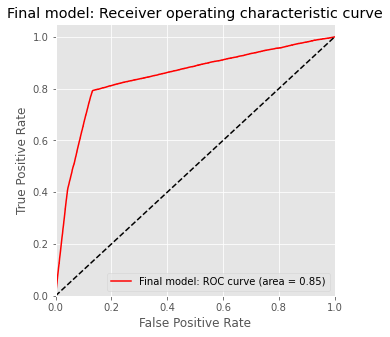

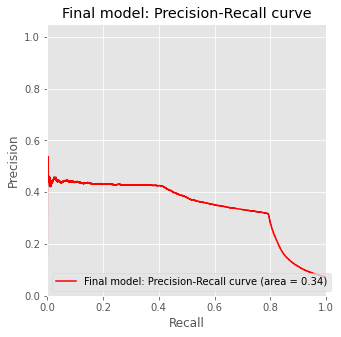

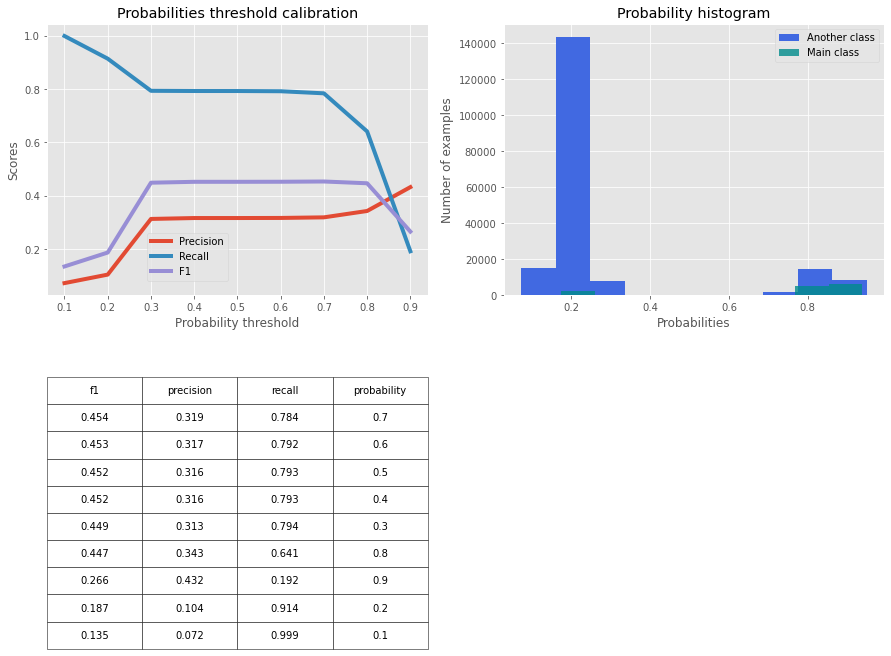

In [73]:
plt.figure(figsize=(5, 5))
plot_roc_curve(fpr, tpr, "Final model", color='r')
print("Baseline: AUC_ROC = %.3f" % auc(fpr, tpr))

plt.figure(figsize=(5, 5))
    
plot_precision_recall_curve(recall, precision, "Final model", color='r')
print("Baseline: AUC_PR = %.3f" % auc(recall, precision))

show_proba_calibration_plots(final_model_test_pred, y_test)

Судя по графикам выше, модель нашла какие-то признаки, которые довольно хорошо разделяют переменные (практически полное отсутствие предсказанных вероятностей на отрезке от 0.3 до 0.7), но тем не менее на тестовой выборке она все равно пропускает довольно много представителей класса 0 как класс 1.<br>
Что можно попробовать еще:
* В первую очередь, необходимо повнимательнее присмотреться к признакам и, возможно, выявить какие-то полезные инсайты. Эта задача осложняется тем, что они полностью анонимизированы и дополнительно нормализованы, судя по значениям, на различные масштабы. Тем не менее думаю, что по графикам дело именно в признаках, а не настройке модели. Так как классы довольно сильно разделены и пограничных случаев не наблюдается.
*  Думал, что балансируя классы на этапе обучения, модель подстраивается искать классы с примерно таким же равным распределением и на тесте, отсюда много ошибок второго рода. Однако, немного поигравшись со скейлером, чтобы получить различные отношения классов, не получил никакого результата. Может, это необходимо делать как-то по-другому.

## Сохранение модели (предсказания в отдельном ноутбуке)

In [85]:
import pickle

In [109]:
with open(filename, 'wb') as file:
    pickle.dump(final_model, file)